In [0]:
import torch
import numpy as np
from torch import nn
from torch import optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This cell determines whether the model will be run on the cpu or the gpu
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = torch.device('cpu')
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device('cuda')

CUDA is available!  Training on GPU ...


In [3]:
# train_size determines how the train_set and dev_set will be formed
# batch_size determines the size of the minibatch in gradient descent
train_size = 0.8
batch_size = 100
lr = 0.01

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

trainset = datasets.MNIST("~/.pytorch/MNIST_data/", train=True, download=True, transform = transform)
testset = datasets.MNIST("~/.pytorch/MNIST_data/", train=False, download=True, transform = transform)

# The train_sampler takes 80% of the dataset randomly as the training set. The rest becomes the development set
indices = list(range(len(trainset)))
np.random.shuffle(indices)
split = int(np.floor(train_size*len(trainset)))
train_idx, valid_idx = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create the three dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True )

# Sizes of the train, dev, and test sets.
print("Size of train set", len(trainloader)*batch_size) 
print("Size of dev set", len(validloader)*batch_size) 
print("Size of test set", len(testloader)*batch_size)



Size of train set 48000
Size of dev set 12000
Size of test set 10000


Label: 5


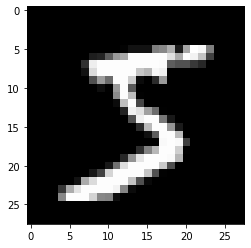

In [4]:
# Information abput the images and labels
image, label = trainset[0]
plt.imshow(image.view(28,28), cmap='gray')
print("Label:", label)

In [5]:
class Classifier(nn.Module):
    def __init__(self):
      super(Classifier, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), stride = 1, padding = 0) 
      self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), stride = 1, padding = 0) 
      self.pool = nn.MaxPool2d(2,2) 
      self.fc1 = nn.Linear((64*12*12), 128) 
      self.fc2 = nn.Linear(128, 10) 

      self.dropout1 = nn.Dropout(p=0.25)
      self.dropout2 = nn.Dropout(p=0.5)

    # Forward Propagation function
    def forward(self, x):
      x = F.relu(self.conv1(x)) # Size now : batch_size 32 26 26
      x = F.relu(self.conv2(x))  # Size now : batch_size 64 24 24
      x = self.pool(x)  # Size now : batch_size 64 12 12
      x = x.view(-1, 64*12*12)  # Size now : batch_size 9216
      x = self.dropout1(x)  # Size now : batch_size 9216
      x = F.relu(self.fc1(x))  # Size now : batch_size 128
      x = self.dropout2(x)  # Size now : batch_size 128
      x = F.log_softmax(self.fc2(x), dim = 1) # Size now : batch_size 10
      return x

# Defining the model, and the default criterion and optimizer
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9)

# If GPU available, we move the model to the GPU
if train_on_gpu:
    model.to(device)
    
print(model)

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)


In [6]:
# This cell finds the initial accuracy, with the randomly initialised neural network

digit_accuracy = [0]*10 # Counts the number of correct predictions for each digit
digit_count = [0]*10 # Counts the number of times that digit appears
test_loss = 0 # Gives a real-number evaluation for the accuracy of the network

for images, labels in testloader:
  images, labels = images.to(device), labels.to(device)
  log_ps = model(images)
  loss = criterion(log_ps, labels)
  ps = torch.exp(log_ps)

  # Finding the predicted class, and the number of correct predictions.
  top_probability, predictions = torch.max(ps, 1)
  correct_tensor = predictions.eq(labels.data.view_as(predictions))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  # Number of times a digit appears, and how many times we predict it correctly.
  for i in range(batch_size):
    label = labels[i]
    digit_accuracy[label] += correct[i].item()
    digit_count[label] += 1
  test_loss += loss.item() * batch_size

# Finding the mean test_accuracy, and test_loss
test_accuracy = np.sum(digit_accuracy)/np.sum(digit_count) * 100.
test_loss /= len(testloader.dataset)

print("Test Loss :", test_loss)
print('\nDigit Accuracy:') 
for idx, (x, y) in enumerate(zip(digit_accuracy, digit_count)):
  print(f"\tfor {idx} : {x/y*100:.4f}% ({int(x)}/{y})")
print(f'Overall Accuracy: {test_accuracy:.6f}% ({np.sum(digit_accuracy)}/{np.sum(digit_count)})') 

# We should get an accuracy around 10%, as random guesses will have a 1 in 10 chance of being correct


Test Loss : 2.3051073789596557

Digit Accuracy:
	for 0 : 0.2041% (2/980)
	for 1 : 18.1498% (206/1135)
	for 2 : 2.1318% (22/1032)
	for 3 : 23.1683% (234/1010)
	for 4 : 50.3055% (494/982)
	for 5 : 6.5022% (58/892)
	for 6 : 0.0000% (0/958)
	for 7 : 0.8755% (9/1028)
	for 8 : 4.7228% (46/974)
	for 9 : 1.9822% (20/1009)
Overall Accuracy: 10.910000% (1091/10000)


In [7]:
# This cell is where the neural network "learns". We will train for about 15 epochs

epochs = 20
min_dev_loss = 10
lrlist = [0.01, 0.006, 0.003, 0.001]

for e in range(1, epochs+1):
  running_loss = loss = 0

  # We define the loss_fn, and the optimisation algorithm
  criterion = nn.NLLLoss()
  lr = lrlist[(e-1)//5]# For the first 10 epochs, lr=0.01, and for the next 10, lr=0.003
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9)

  model.train()
  print(f"\nTraining Model (Epoch {e}) ...", end = "")
  for idx, (images, labels) in enumerate(trainloader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()  # BackPropagation
    optimizer.step() # Gradient Descent

    running_loss += loss.item()*batch_size

    percent = (idx / len(trainloader))*100
    if percent % 10 == 0:
      print(f" -- {percent}% ", end = "") # To get an idea of the progress in training.
    
  else:
    print(f"-- 100%\nTesting Model (Epoch {e}) ...")
    dev_loss = dev_accuracy = 0

    model.eval()
    with torch.no_grad():
      for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        ps = torch.exp(log_ps)

        # Finding the predicted clss, and number of correct predictions
        top_probability, predictions = torch.max(ps, 1)
        correct_tensor = predictions.eq(labels.data.view_as(predictions))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

        dev_loss += loss.item() * batch_size
        dev_accuracy += np.sum(correct) * 100.
      # Finding the mean developmental loss
      dev_accuracy /= len(validloader.sampler)
      dev_loss /= len(validloader.sampler)
        
        
  
    print(f'Epoch: {e} of {epochs} - Training Loss: {running_loss/len(trainloader):.6f} - Development Loss: {dev_loss:.6f}')
    print(f'Accuracy: {dev_accuracy.item():.6f}%', end = "\t")
    if min_dev_loss > dev_loss:
      print(f"Validation Loss decreased ({min_dev_loss:.6f} --> {dev_loss:.6f}) !! Saving Model ... ")
      min_dev_loss = dev_loss
      torch.save(model.state_dict(), 'mnist_cnn.pt')
    else:
       print()
    
        



Training Model (Epoch 1) ... -- 0.0%  -- 10.0%  -- 20.0%  -- 30.0%  -- 40.0%  -- 50.0%  -- 60.0%  -- 70.0%  -- 80.0%  -- 90.0% -- 100%
Testing Model (Epoch 1) ...
Epoch: 1 of 20 - Training Loss: 43.651164 - Development Loss: 0.095496
Accuracy: 96.966667%	Validation Loss decreased (10.000000 --> 0.095496) !! Saving Model ... 

Training Model (Epoch 2) ... -- 0.0%  -- 10.0%  -- 20.0%  -- 30.0%  -- 40.0%  -- 50.0%  -- 60.0%  -- 70.0%  -- 80.0%  -- 90.0% -- 100%
Testing Model (Epoch 2) ...
Epoch: 2 of 20 - Training Loss: 12.753115 - Development Loss: 0.064406
Accuracy: 98.025000%	Validation Loss decreased (0.095496 --> 0.064406) !! Saving Model ... 

Training Model (Epoch 3) ... -- 0.0%  -- 10.0%  -- 20.0%  -- 30.0%  -- 40.0%  -- 50.0%  -- 60.0%  -- 70.0%  -- 80.0%  -- 90.0% -- 100%
Testing Model (Epoch 3) ...
Epoch: 3 of 20 - Training Loss: 9.206463 - Development Loss: 0.054805
Accuracy: 98.333333%	Validation Loss decreased (0.064406 --> 0.054805) !! Saving Model ... 

Training Model (Ep

In [8]:
# This cell finds the overall and digit-wise accuracy of the neural network after the network has been trained. We aim to hit about 99% accuracy 

# We first load the model with the lowest validation error of the 20 epochs
model.load_state_dict(torch.load('mnist_cnn.pt'))

digit_accuracy = [0]*10 
digit_count = [0]*10
test_loss = 0

for images, labels in testloader:
  images, labels = images.to(device), labels.to(device)
  log_ps = model(images)
  loss = criterion(log_ps, labels)
  ps = torch.exp(log_ps)

  top_probability, predictions = torch.max(ps, 1)
  correct_tensor = predictions.eq(labels.data.view_as(predictions))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  for i in range(batch_size):
    label = labels[i]
    digit_accuracy[label] += correct[i].item()
    digit_count[label] += 1
  test_loss += loss.item() * batch_size

test_accuracy = np.sum(digit_accuracy)/np.sum(digit_count) * 100.
test_loss /= len(testloader.dataset)

print("Test Loss :", test_loss)
print('\nDigit Accuracy:') 
for idx, (x, y) in enumerate(zip(digit_accuracy, digit_count)):
  print(f"\tfor {idx} : {x/y*100:.4f}% ({int(x)}/{y})")
print(f'Overall Accuracy: {test_accuracy:.3f}% ({np.sum(digit_accuracy)}/{np.sum(digit_count)})') 



Test Loss : 0.027415575875202193

Digit Accuracy:
	for 0 : 99.4898% (975/980)
	for 1 : 99.8238% (1133/1135)
	for 2 : 99.5155% (1027/1032)
	for 3 : 99.2079% (1002/1010)
	for 4 : 99.0835% (973/982)
	for 5 : 98.8789% (882/892)
	for 6 : 98.8518% (947/958)
	for 7 : 99.0272% (1018/1028)
	for 8 : 99.2813% (967/974)
	for 9 : 98.0178% (989/1009)
Overall Accuracy: 99.130% (9913/10000)


In [9]:
# This cell compares the time required to train a network , on a CPU vs a GPU.
import time
dur = {} # This dictionary contains the duration it takes for each device to train the network per a mini-batch
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==5:
          dur[device] = (time.time() - start)/5
          break
    print(f"Device = {device}\t Time per batch: {dur[device]:.6f} seconds")

print(f"The GPU is {dur['cpu']/dur['cuda']:.3f} times faster than the CPU") 

Device = cpu	 Time per batch: 0.037600 seconds
Device = cuda	 Time per batch: 0.000663 seconds
The GPU is 56.695 times faster than the CPU


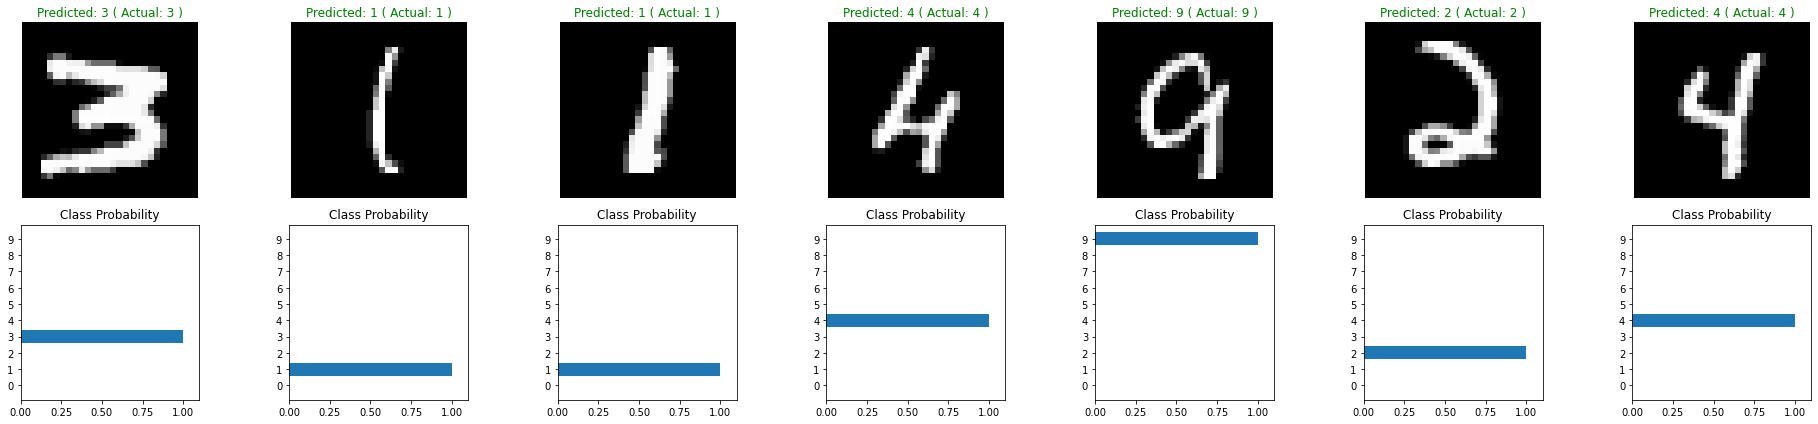

In [12]:
# We show the results of our network here
dataiter = iter(testloader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
ps = torch.exp(output)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig1 = plt.figure(figsize=(28, 6))

images, labels, ps = images.cpu(), labels.cpu(), ps.cpu().detach().numpy()
num = 7
for idx in np.arange(num):
    ax1 = fig1.add_subplot(2, num, idx+1)
    ax2 = fig1.add_subplot(2, num, idx+1+num)

    ax1.imshow(images[idx].resize_(1, 28, 28).numpy().squeeze(), cmap = "gray")
    ax1.axis('off')
    ax1.set_title(f"Predicted: {preds[idx]} ( Actual: {labels[idx]} )", color=("green" if preds[idx]==labels[idx] else "red"))
    ax2.barh(np.arange(10), ps[idx])
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
